In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing our models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import metrics   
from sklearn.model_selection import GridSearchCV 
#importing our model evaluators
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report, roc_auc_score, auc

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# 1. Data Preprocessing

In [68]:
train_df = pd.read_csv(r'train.csv')
train_df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [3]:
test_df = pd.read_csv(r'test.csv')
test_df.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [4]:
print("Training data shape: ", train_df.shape)
print("Testing data shape: ", test_df.shape)

Training data shape:  (414, 8)
Testing data shape:  (276, 7)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       276 non-null    int64  
 1   gravity  276 non-null    float64
 2   ph       276 non-null    float64
 3   osmo     276 non-null    int64  
 4   cond     276 non-null    float64
 5   urea     276 non-null    int64  
 6   calc     276 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 15.2 KB


In [7]:
train_df.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [69]:
#dropping ID as it has no relevance in kidney stones detection
train_df = train_df.drop(['id'], axis = 1)


In [9]:
train_df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


# 2. EDA

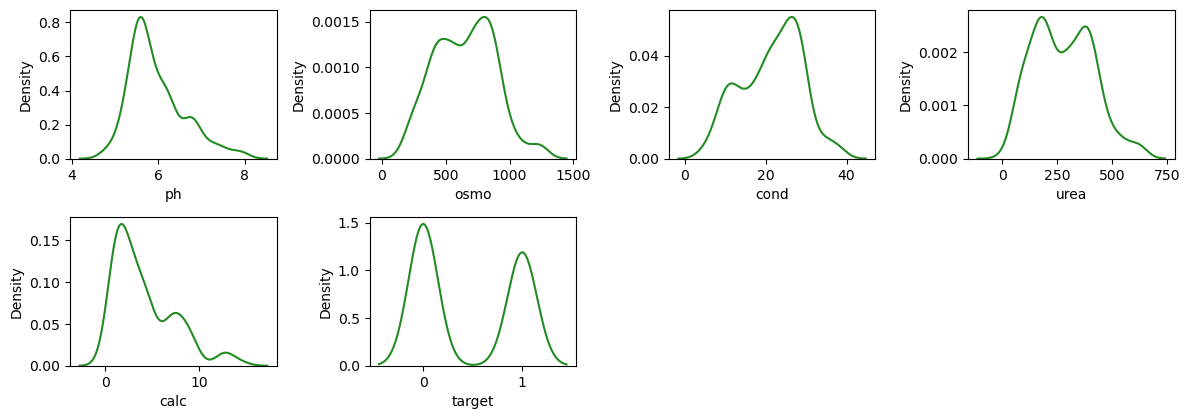

In [10]:
# Understanding the different variables with univariate analysis
plt.figure(figsize=(12,8))
for i in range(1, len(train_df.columns)):
    plt.subplot(4,4,i)
    sns.kdeplot(x=train_df[train_df.columns[i]], label='train', color='forestgreen')
    plt.tight_layout()

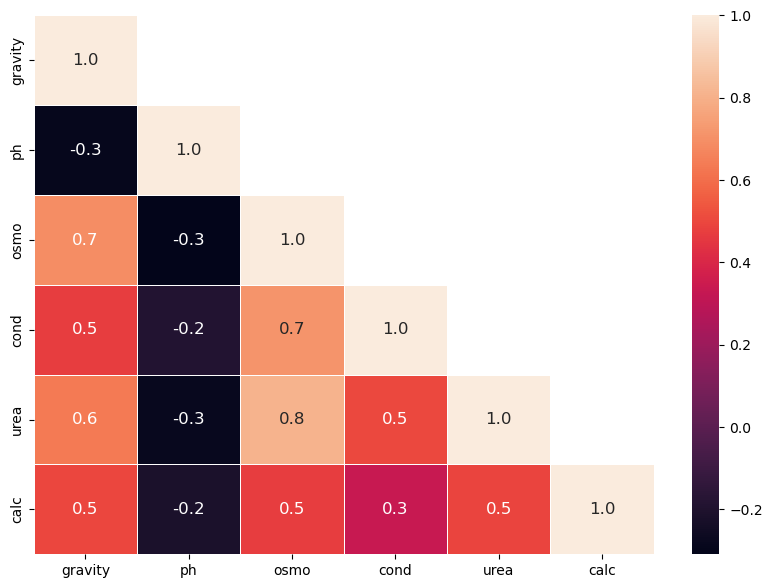

In [13]:
# checking for correlation between any of the values 
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
corr = train_df[features].corr(method='pearson')
triu = np.triu(corr)
np.fill_diagonal(triu, False)

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt='.1f',annot_kws={"size":12}, linewidth=.6, mask=triu);

The above correlation matrix shows the following medium to strong correlations:
- Urea & calc (0.5)
- Osmo & calc (0.5)
- Gravity & calc (0.5)
- Osmo & cond (0.7)
- Osmo & urea (0.8)


Because of the amount of correlation, features will have to be engineered as opposed to dropped when modelling.

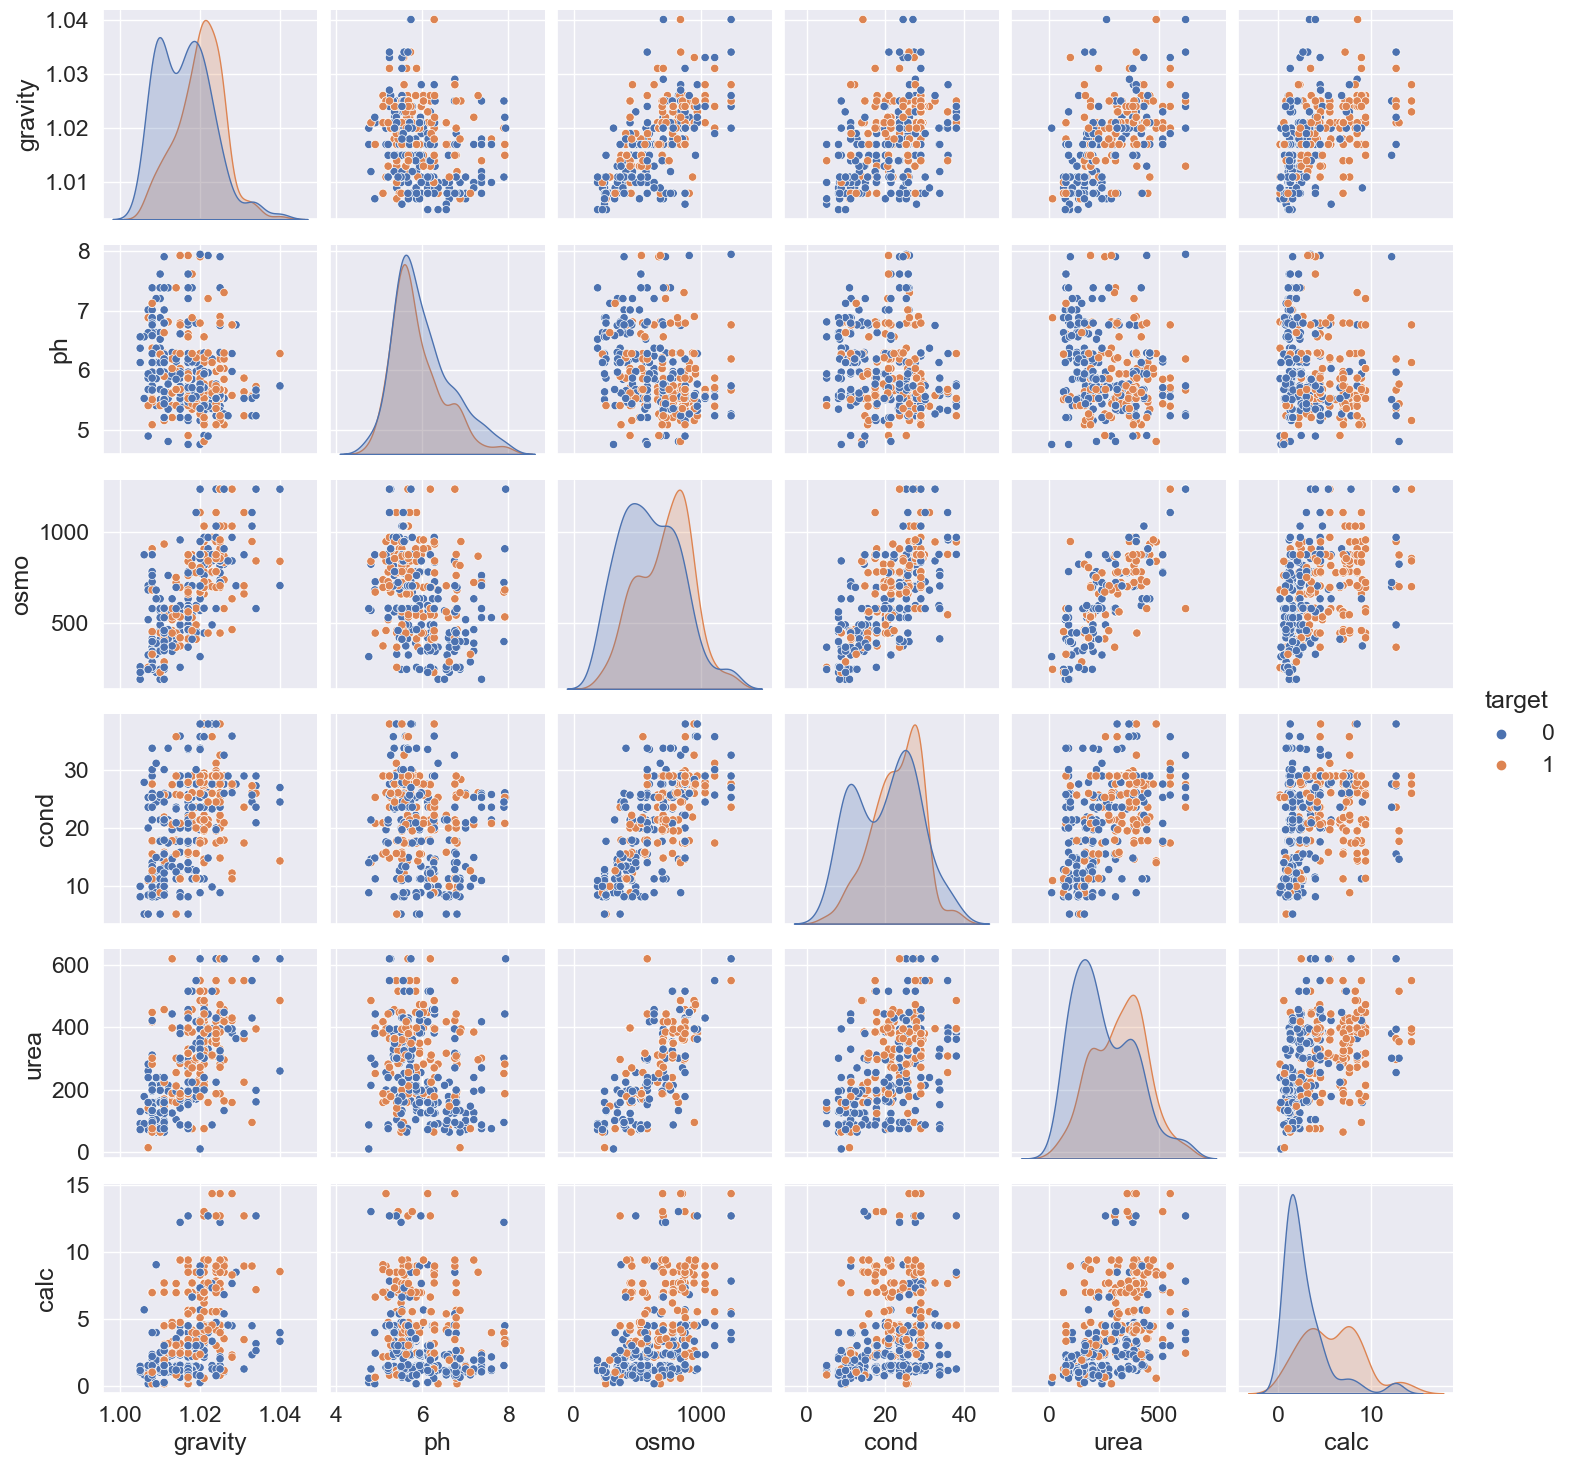

In [29]:
# Plot the pairs plot of all variables in our dataframe, separating class belonging by color
sns.pairplot(train_df, hue='target')

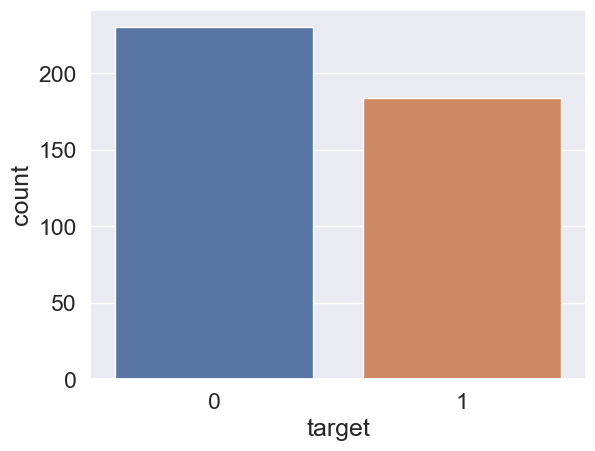

In [30]:
#Plot class count
sns.countplot(x='target', data=train_df)
plt.show()

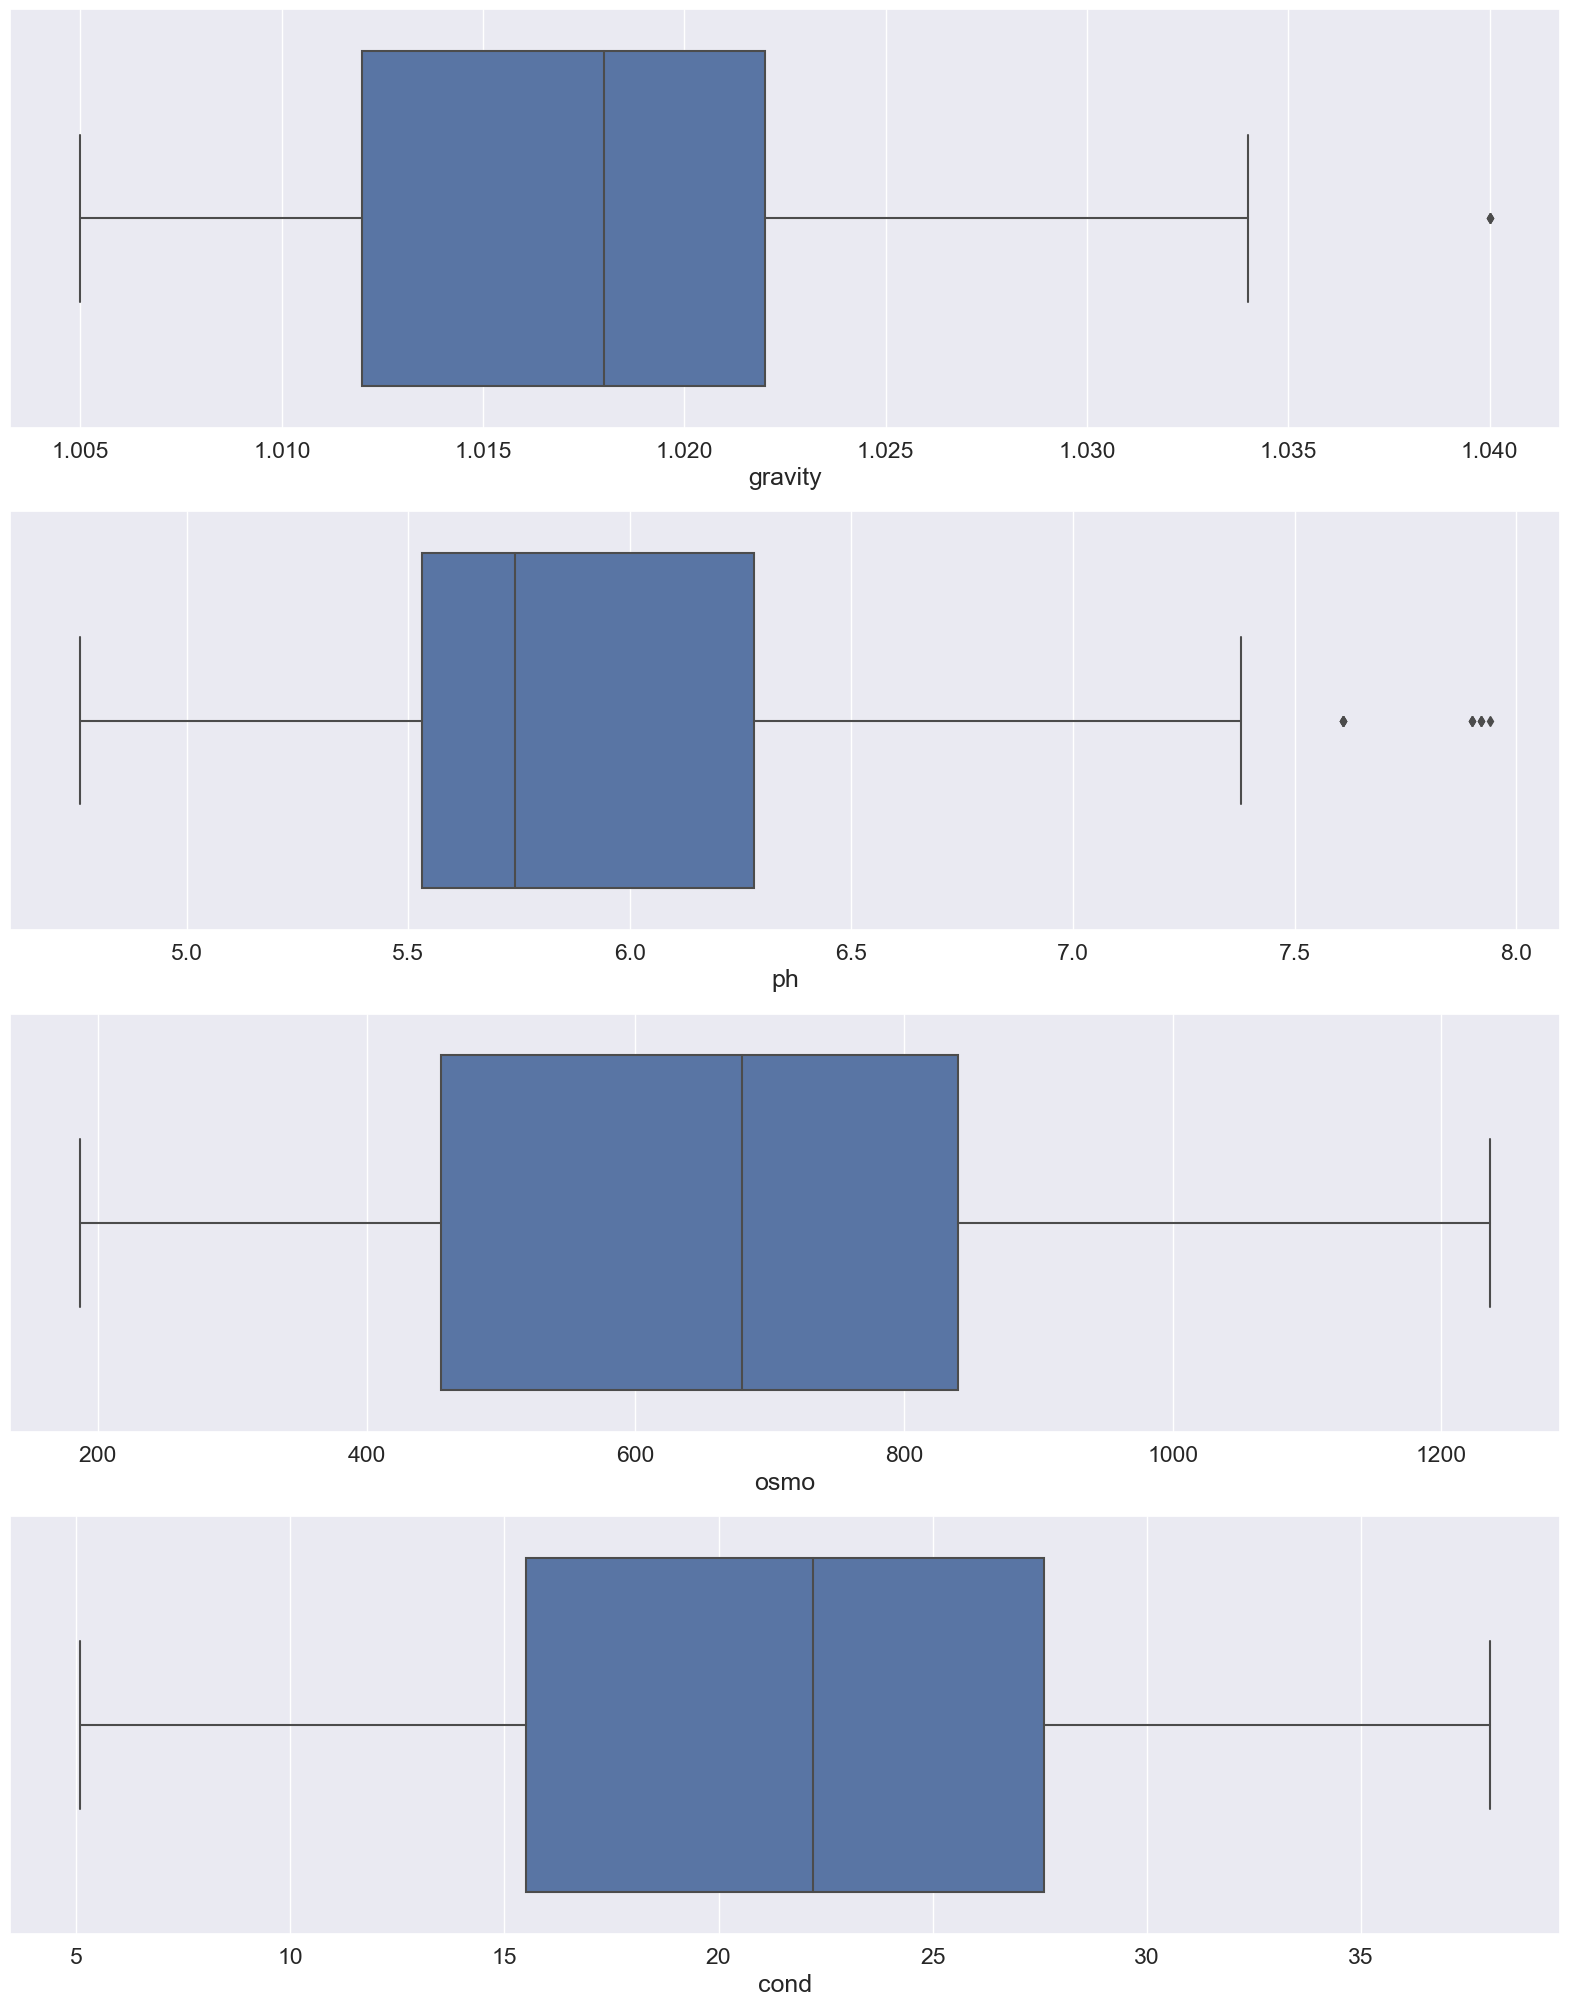

In [31]:
# Check for Outliers:
# Output a series of boxplots, visualising values for each column in the dataset
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(20,25))
count = 0
for i in range(4):
    sns.boxplot(x = train_df[train_df.columns[i]],ax=ax[i])
    count = count+1

There appears to be some outliers in the dataset. We will remove these after running initial models to improve performance. 

In [50]:
#identifying the columns to be scales
num_cols = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

In [32]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
#train_df.head()

,gravity,ph,osmo,cond,urea,calc,target
0,-0.734032,0.365623,-0.889728,-0.884388,-1.134869,-0.829136,0
1,1.065904,-0.865897,0.219521,0.288059,0.846384,0.020338,0
2,-1.334010,0.272090,-1.196904,0.407969,-0.878040,1.532589,0
3,0.465925,-1.629751,-0.893994,-0.084992,0.875736,0.782687,1
4,0.465925,-0.663242,0.949065,-0.484690,0.780342,-0.592652,1


# 3. Initial Modelling - Original Dataset

In [32]:
X = train_df
y = train_df['target']

In [33]:
X.shape

(414, 7)

In [34]:
y.shape

(414,)

In [35]:
#assigning our target variable and predictors
from sklearn.model_selection import train_test_split
X = train_df.drop(columns = ['target'])
y = train_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 40, stratify=y)

In [36]:
# Start with logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy_tr = log_reg.score(X_train, y_train)
accuracy_ts = log_reg.score(X_test, y_test)
print("Logistic Regression Accuracy on Training :",accuracy_tr)
print("Logistic Regression Accuracy on Testing :",accuracy_ts)

Logistic Regression Accuracy on Training : 0.7439446366782007
Logistic Regression Accuracy on Testing : 0.688


In [37]:
# Use classification report to assess the accuracy of the prediction
log_pred = log_reg.predict(X_test)
report = classification_report(y_test,log_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74        69
           1       0.70      0.54      0.61        56

    accuracy                           0.69       125
   macro avg       0.69      0.67      0.67       125
weighted avg       0.69      0.69      0.68       125



Text(0.5, 71.15624999999999, 'Predicted')

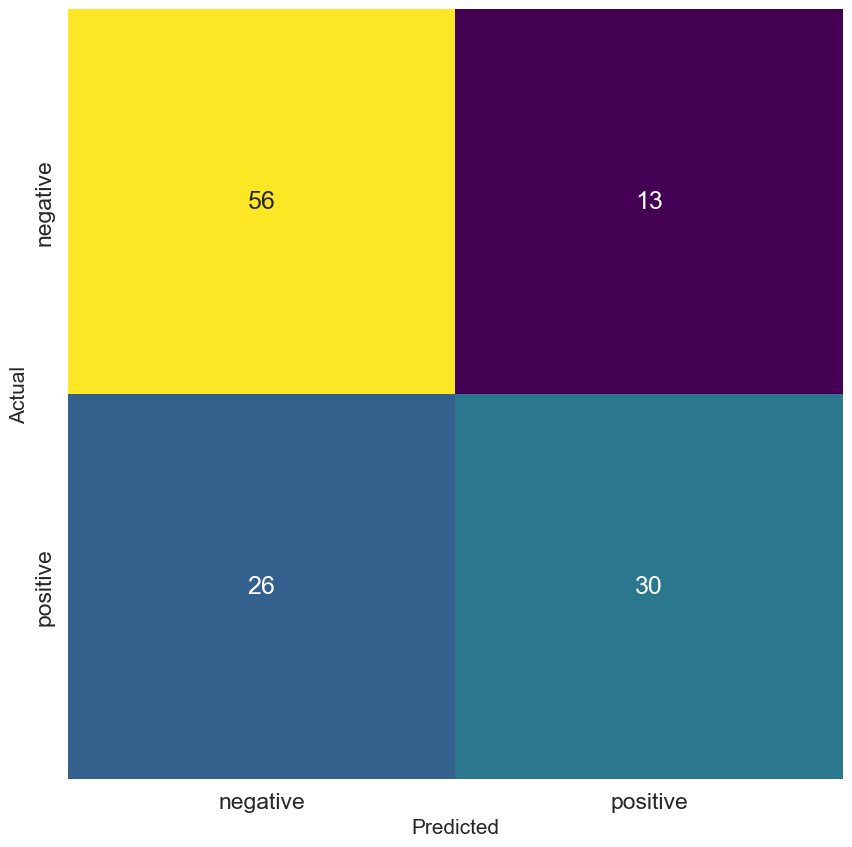

In [38]:
# LR appears to struggle detecting patients with kidney stones
#create confusion matrix
conf_matrix = confusion_matrix(y_test,log_pred)
conf_matrix = pd.DataFrame(data = conf_matrix,
                              columns=['negative','positive'],
                              index=['negative','positive'])

#plot confusion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix,cmap='viridis',annot=True,fmt='.5g',cbar=False)
plt.ylabel('Actual',size=15)
plt.xlabel('Predicted',size=15)

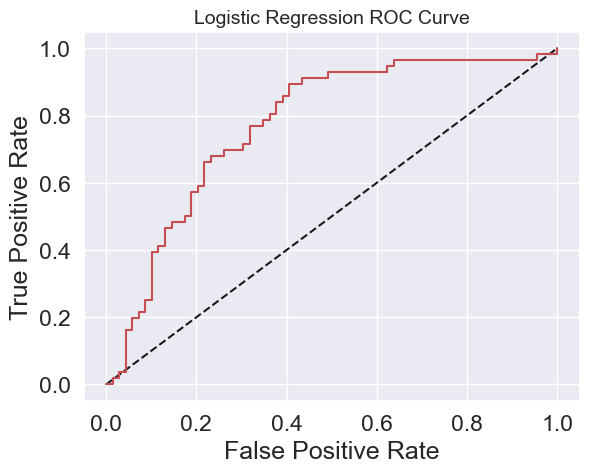

In [39]:
log_pred_prob = log_reg.predict_proba(X_test)[:,1]
false_positive, true_positive, thresholds = roc_curve(y_test, log_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(false_positive, true_positive, label='Logistic Regression',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve',fontsize=14)
plt.show();

In [40]:
model = LogisticRegression()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.744


In [41]:
# Naives Bayes Model
nb = GaussianNB()
nb.fit(X_train,y_train)
predict_nb_y = nb.predict(X_test)
accuracy_nb_tr = nb.score(X_train,y_train)
accuracy_nb = nb.score(X_test,y_test)
print("Naives Bayes accuracy on Training :",accuracy_nb_tr)
print("Naives Bayes accuracy on Testing :",accuracy_nb)

Naives Bayes accuracy on Training : 0.6816608996539792
Naives Bayes accuracy on Testing : 0.704


In [42]:
nb_report = classification_report(y_test,predict_nb_y)
print(nb_report)

              precision    recall  f1-score   support

           0       0.75      0.70      0.72        69
           1       0.66      0.71      0.68        56

    accuracy                           0.70       125
   macro avg       0.70      0.70      0.70       125
weighted avg       0.71      0.70      0.70       125



Text(0.5, 71.15624999999999, 'Predicted')

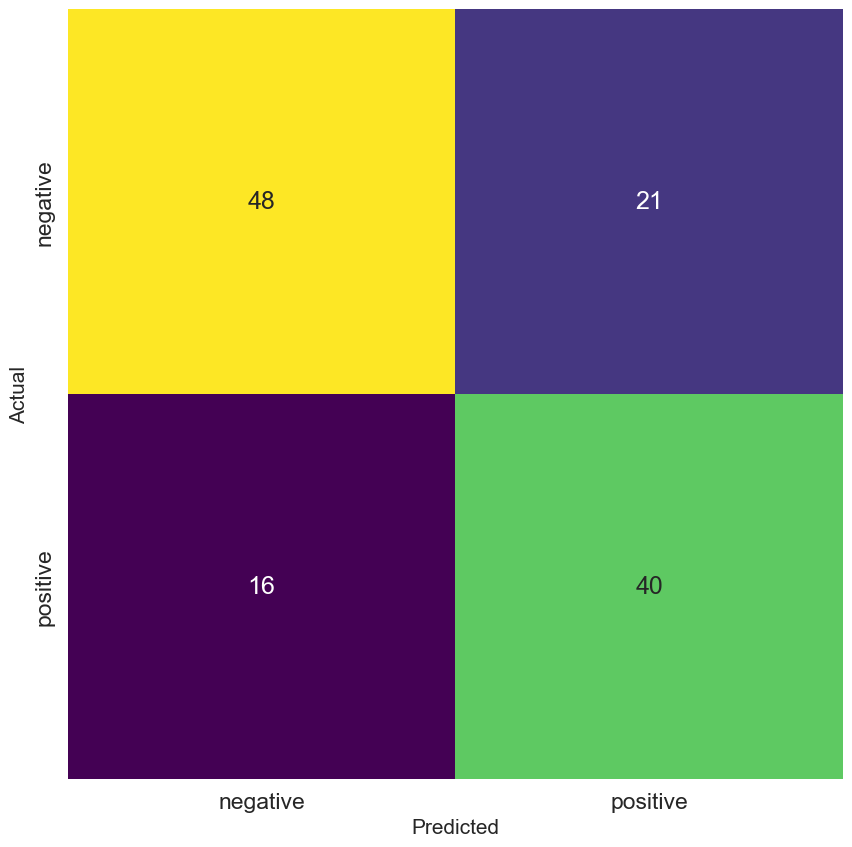

In [43]:
# Naives Bayes model did a much better job of detecting positive cases of kidney stones. 
#create confusion matrix
conf_matrix = confusion_matrix(y_test,predict_nb_y)
conf_matrix = pd.DataFrame(data = conf_matrix,
                              columns=['negative','positive'],
                              index=['negative','positive'])

#plot confusion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix,cmap='viridis',annot=True,fmt='.5g',cbar=False)
plt.ylabel('Actual',size=15)
plt.xlabel('Predicted',size=15)

# Increased detection in positive cases but a reduction in the number of correctly identified negative cases.

nb_pred_prob = nb.predict_proba(X_test)[:,1]
false_positive, true_positive, thresholds = roc_curve(y_test, nb_pred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(false_positive, true_positive, label='SVM',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naives Bayes ROC Curve',fontsize=14)
plt.show();

In [45]:
model = GaussianNB()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.682


# 4. Feature Engineering

The scores on the initial models are quite low. To try improve this the following steps will be taken:
- Remove outliers
- Scale features - polynomial scaling
- If still no improvement - address imbalance in the target variable

In [70]:
# Remove outliers
# Remove the points outside the interquartile range
outliers = ['ph', 'gravity']
for col in outliers:
  for x in [col]:
      q75,q25 = np.percentile(train_df.loc[:,x],[75,25])
      intr_qr = q75-q25
  
      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)

      train_df = train_df[train_df[x] > min]
      train_df = train_df[train_df[x] < max]

## Reset index
train_df = train_df.reset_index(drop=True)   


In [71]:
train_df.shape

(399, 7)

15 datapoints dropped as a result of removing outliers. Next to scale the features

In [72]:
X = train_df.drop(columns = ['target'])
y = train_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y)

In [73]:
# Preprocess the numerical features by scaling them and adding polynomial features
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train = scaler.fit_transform(X_train)
X_train = poly.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = poly.transform(X_test)

Hyperparameter grid features for logistic regression:
- penalty specifies the norm used in the penalization of the model. l1 and l2 refer to L1 and L2 regularization respectively.
- C is the inverse of regularization strength. Smaller values of C result in stronger regularization.
- solver specifies the algorithm to use for optimization. liblinear is a good choice for small datasets, while lbfgs and saga are better for larger datasets.

In [74]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1, 5, 10, 20],
    'solver': ['liblinear', 'saga']
}
# grid search on best hyperparameters
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(X_train, y_train)

#train model with best hyperparameters
best_mod = grid_search.best_estimator_
best_mod.fit(X_train, y_train)

#Prediction
y_pred = best_mod.predict(X_test)
y_prob = best_mod.predict_proba(X_test)[:,1]

#evaluation
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Confusion matrix: \n{confusion}')
print(f'ROC AUC score: {roc_auc}')



C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: T

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.775
Confusion matrix: 
[[33 11]
 [ 7 29]]
ROC AUC score: 0.8390151515151515


C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\ewalshe\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: T

Text(0.5, 71.15624999999999, 'Predicted')

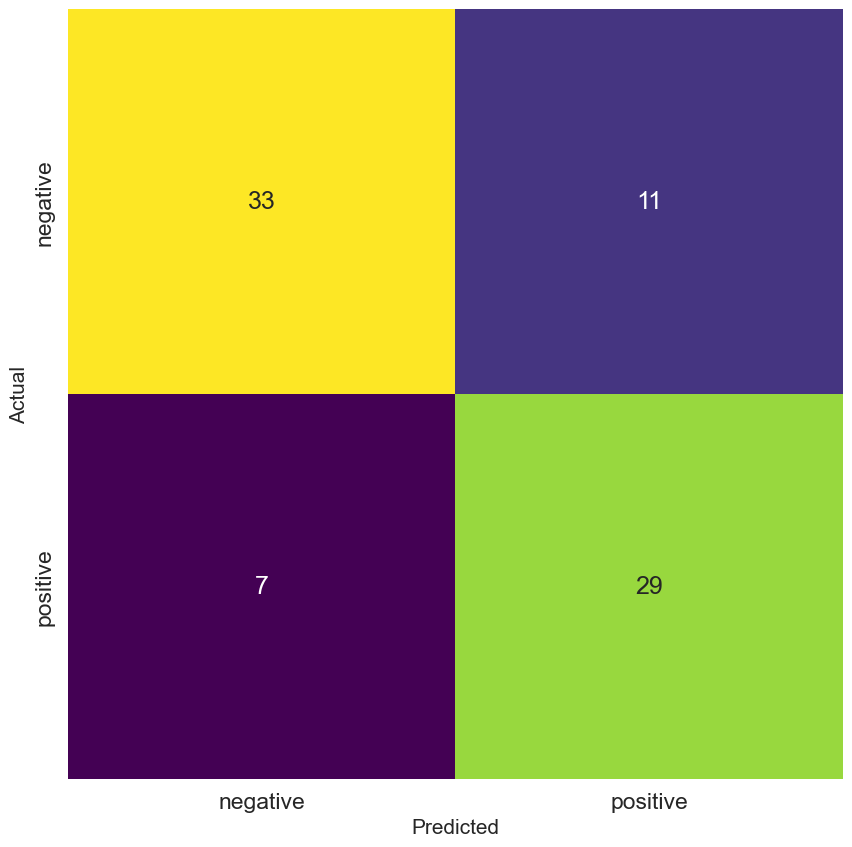

In [75]:
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data = conf_matrix,
                              columns=['negative','positive'],
                              index=['negative','positive'])
#plot confusion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix,cmap='viridis',annot=True,fmt='.5g',cbar=False)
plt.ylabel('Actual',size=15)
plt.xlabel('Predicted',size=15)

Best results so far on the model as a result of the feature engineering with testing accuracy of 0.775 & ROC AUC score of 0.839